In [1]:
# Common imports
import os
import sys
from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import yaml

# Torch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Albumentations for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Ultralytics YOLO for loading YOLOv11
!pip install ultralytics
from ultralytics import YOLO

In [3]:
#Define the Dataset Class for IP102
class IP102Dataset(Dataset):
    """A dataset class for the IP102 dataset in YOLO format."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with images and labels (e.g., /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train).
            transform (callable, optional): Optional data augmentation to be applied on a sample.
        """
        self.data_dir = Path(data_dir)
        self.image_list = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = str(self.data_dir / img_name)
        label_path = str(self.data_dir.parent.parent / 'labels' / self.data_dir.name / (img_name.replace('.jpg', '.txt')))

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        else:
            boxes = []

        # Parse boxes
        bboxes = []
        labels = []
        for box in boxes:
            class_id, center_x, center_y, width, height = box
            # Convert YOLO format (normalized) to Pascal VOC format (absolute coordinates)
            img_height, img_width = img.shape[:2]
            xmin = (center_x - width / 2) * img_width
            ymin = (center_y - height / 2) * img_height
            xmax = (center_x + width / 2) * img_width
            ymax = (center_y + height / 2) * img_height
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(class_id))

        if self.transform:
            transformed = self.transform(image=img, bboxes=bboxes, class_labels=labels)
            img = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["class_labels"]

        if len(bboxes) > 0:
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            bboxes = torch.zeros((0, 4))
            labels = torch.zeros((0,), dtype=torch.long)

        return img, bboxes, labels

In [4]:
# Define Data Augmentation
transform = A.Compose([
    A.LongestMaxSize(416, p=1),
    A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area=20))

/tmp/ipykernel_131/3553826755.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),


In [5]:
# Set Up the Dataset and DataLoader
train_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
val_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

train_dataset = IP102Dataset(train_data_dir, transform=transform)
val_dataset = IP102Dataset(val_data_dir, transform=transform)

def collate_fn(batch):
    images, bboxes, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, bboxes, labels

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

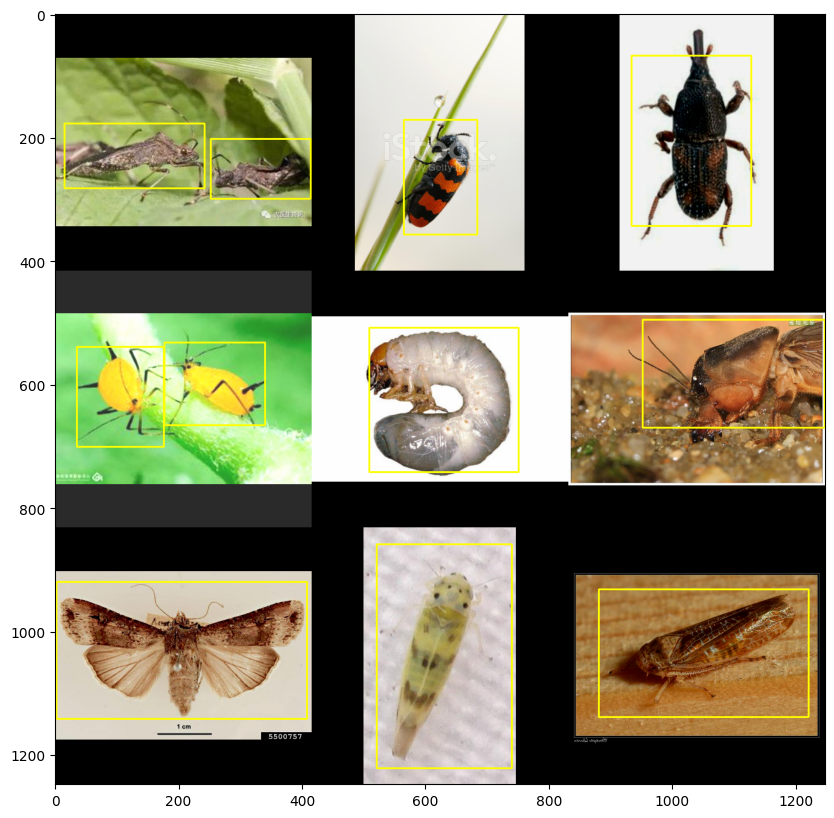

In [6]:
# Sanity Check of the Dataset
hlines = []
for i in range(3):
    vlines = []
    for j in range(3):
        idx = random.randint(0, len(train_dataset) - 1)
        img, bboxes, labels = train_dataset[idx]
        img = img.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = (img * 255).astype(np.uint8)

        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

        vlines.append(img)
    hlines.append(cv2.vconcat(vlines))

final_img = cv2.hconcat(hlines)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(final_img)
plt.show()

In [7]:
# Load Pre-trained YOLOv8 Model
model = YOLO("/kaggle/input/yolo11/pytorch/default/1/yolo11l.pt")

In [8]:
# Copy the original ip102.yaml to the working directory and modify the paths
original_yaml_path = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/ip102.yaml"
new_yaml_path = "/kaggle/working/ip102_corrected.yaml"

# Read the original YAML file
with open(original_yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)

# Update the paths to the correct absolute paths
yaml_content['train'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
yaml_content['val'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

# Save the modified YAML file
with open(new_yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Modified ip102.yaml saved to {new_yaml_path}")
print("Updated paths:")
print(f"train: {yaml_content['train']}")
print(f"val: {yaml_content['val']}")

Modified ip102.yaml saved to /kaggle/working/ip102_corrected.yaml
Updated paths:
train: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train
val: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val


In [ ]:
# Train the Model Using Ultralytics YOLO API
# The Ultralytics YOLO implementation simplifies training by handling the loss function and training loop internally.
# We just need to provide the dataset configuration and training parameters.

# Train the model
results = model.train(
    data=new_yaml_path,
    epochs=50,
    imgsz=416,
    batch=16,
    warmup_epochs=5,
    device=0,
    patience=15,
    save=True,
    project="/kaggle/working/yolo_training",
    name="ip102_yolov11l",
    cos_lr=True,
    lr0=0.001,
    augment=True,
    verbose=True
)

Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/ip102_corrected.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo11/pytorch/default/1/yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ip102_yolov11l2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

train: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [00:57<00:00, 308.41it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.5±4.5 MB/s, size: 25.0 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:04<00:00, 318.14it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
Plotting labels to /kaggle/working/yolo_training/ip102_yolov11l2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo_training/ip102_yolov11l2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.62G      1.446      3.054      1.625         55        416: 100%|██████████| 1103/1103 [08:21<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]


                   all       1329       1621      0.604      0.342      0.288      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.59G      1.353      2.098      1.487         40        416: 100%|██████████| 1103/1103 [08:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]


                   all       1329       1621      0.603      0.316      0.351      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.65G      1.383      2.109      1.512         45        416: 100%|██████████| 1103/1103 [08:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


                   all       1329       1621      0.472      0.331      0.312      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.71G      1.419      2.218      1.559         36        416: 100%|██████████| 1103/1103 [07:58<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


                   all       1329       1621       0.47      0.284      0.245      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.78G      1.464       2.38      1.603         43        416: 100%|██████████| 1103/1103 [07:54<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]


                   all       1329       1621      0.558      0.252      0.249      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.84G      1.473      2.437      1.624         37        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]


                   all       1329       1621      0.522      0.279      0.281      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.91G      1.438      2.275      1.586         37        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


                   all       1329       1621      0.541      0.346      0.332      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.97G      1.405      2.134       1.57         47        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]


                   all       1329       1621      0.472      0.408      0.346      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.04G       1.39      2.035      1.557         52        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]


                   all       1329       1621      0.465      0.454      0.392      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       6.1G      1.367      1.941      1.542         45        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


                   all       1329       1621      0.465      0.459      0.421      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.16G       1.36      1.896      1.534         48        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


                   all       1329       1621      0.453      0.485      0.429       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.23G      1.337      1.842      1.519         42        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]


                   all       1329       1621      0.527      0.462      0.467      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.29G      1.321      1.768      1.509         26        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]


                   all       1329       1621      0.379      0.537      0.474      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.36G      1.311      1.739      1.503         40        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]


                   all       1329       1621      0.486       0.52       0.48      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.42G      1.307      1.705      1.498         35        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


                   all       1329       1621      0.485      0.543      0.496      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.48G      1.299      1.659      1.496         35        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]


                   all       1329       1621      0.512      0.532      0.532      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.55G      1.287      1.611      1.484         40        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


                   all       1329       1621      0.534      0.537       0.54      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.61G       1.28      1.578      1.477         37        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


                   all       1329       1621      0.528      0.545      0.563      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.68G      1.268      1.543       1.47         32        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]


                   all       1329       1621      0.482      0.605      0.569      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.74G      1.265      1.513      1.471         39        416: 100%|██████████| 1103/1103 [07:51<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]


                   all       1329       1621      0.522      0.574       0.58      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.81G      1.246      1.487      1.457         36        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


                   all       1329       1621      0.567      0.577      0.586      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.87G      1.246      1.458      1.455         38        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


                   all       1329       1621      0.493      0.639      0.588      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.94G      1.239      1.439       1.45         48        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


                   all       1329       1621      0.543      0.601      0.604      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         7G      1.225      1.394       1.44         34        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


                   all       1329       1621      0.594      0.576      0.615      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.06G      1.217      1.379      1.438         43        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]


                   all       1329       1621      0.524      0.637      0.616      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.13G      1.215      1.345      1.433         38        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]


                   all       1329       1621      0.565      0.587      0.629      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.19G      1.204       1.33      1.431         40        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


                   all       1329       1621      0.536      0.653      0.653      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.26G      1.197      1.311      1.422         36        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]


                   all       1329       1621       0.54      0.633      0.634      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.32G       1.19      1.286      1.418         42        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]


                   all       1329       1621      0.537      0.637      0.653      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.39G      1.177       1.26      1.412         72        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]


                   all       1329       1621      0.596      0.621      0.651      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.45G      1.172      1.232      1.404         43        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]


                   all       1329       1621      0.529      0.669      0.667      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.51G      1.161      1.205      1.399         35        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.77it/s]


                   all       1329       1621      0.561      0.618      0.667      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.58G      1.154      1.194      1.398         47        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


                   all       1329       1621      0.619      0.616      0.665      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.69G       1.15      1.171      1.392         39        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.74it/s]


                   all       1329       1621      0.572      0.635      0.658      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       7.8G      1.137      1.138      1.382         42        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]


                   all       1329       1621      0.605      0.614      0.672      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.86G      1.133      1.123      1.383         41        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


                   all       1329       1621      0.575      0.666      0.674      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.37G      1.122      1.099      1.378         35        416: 100%|██████████| 1103/1103 [07:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


                   all       1329       1621      0.565      0.696      0.683      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.92G      1.119      1.085      1.373         42        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]


                   all       1329       1621      0.542        0.7      0.679      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.92G      1.109      1.065      1.365         47        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


                   all       1329       1621      0.546      0.696      0.678      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.92G      1.097      1.047      1.357         34        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.75it/s]


                   all       1329       1621      0.536      0.694      0.676      0.441
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.92G      1.041     0.7645      1.443         15        416: 100%|██████████| 1103/1103 [07:52<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


                   all       1329       1621      0.562      0.686       0.67       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.92G       1.02     0.7265      1.475         16        416:   1%|          | 6/1103 [00:02<07:42,  2.37it/s]

In [ ]:
# Evaluate on Validation Set
val_results = model.val(data=new_yaml_path, split="val")
print(f"Validation mAP@0.5: {val_results.box.map50:.4f}")
print(f"Validation mAP@0.5:0.95: {val_results.box.map:.4f}")

In [ ]:
# Export for Mobile Deployment
# Export to ONNX
model.export(format="onnx", imgsz=416)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import yaml
import os

# Step 1: Load the Class Names from ip102.yaml
yaml_path = "/kaggle/working/ip102_corrected.yaml"
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
class_names = yaml_content['names']  # List of 102 pest class names

# Step 2: Load the Trained YOLOv11 Model
model_weights_path = "/kaggle/working/yolo_training/ip102_yolov11x2/weights/best.pt"
model = YOLO(model_weights_path)
print(f"Loaded trained YOLOv11 model from {model_weights_path}")

# Step 3: Define the Directory of Unseen Test Images
test_images_dir = "/kaggle/input/pest-test-images/"  # Directory containing test images
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Step 4: Perform Inference on Each Test Image
for image_file in image_files:
    unseen_image_path = os.path.join(test_images_dir, image_file)
    img = cv2.imread(unseen_image_path)
    if img is None:
        print(f"Could not load image from {unseen_image_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_height, img_width = img.shape[:2]
    print(f"Processing image: {image_file} ({img_width}x{img_height})")

    # Run inference with a lower confidence threshold
    results = model.predict(
        source=unseen_image_path,
        conf=0.1,  # Lower confidence threshold
        iou=0.7,   # IoU threshold for NMS
        imgsz=416, # Match training image size
        device=0,  # Use GPU
        verbose=False
    )
    result = results[0]

    # Extract bounding boxes, class IDs, and confidence scores
    boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else np.array([])
    confidences = result.boxes.conf.cpu().numpy() if result.boxes else np.array([])
    class_ids = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else np.array([])

    # Draw bounding boxes and labels on the image
    if len(boxes) > 0:
        for box, conf, class_id in zip(boxes, confidences, class_ids):
            xmin, ymin, xmax, ymax = map(int, box)
            label = class_names[class_id]
            confidence = conf

            # Draw the bounding box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Add label with class name and confidence
            label_text = f"{label}: {confidence:.2f}"
            cv2.putText(img, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print(f"No detections for {image_file} with confidence threshold 0.1")

    # Step 5: Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Unseen Image: {image_file}")
    plt.show()

    # Step 6: Print Detection Results
    print(f"\nDetection Results for {image_file} (Confidence Threshold 0.1):")
    if len(boxes) > 0:
        for box, conf, class_id in zip(boxes, confidences, class_ids):
            print(f"Class: {class_names[class_id]}, Confidence: {conf:.2f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
    else:
        print("No detections found. Consider lowering the confidence threshold or retraining the model.")